In [1]:
using IMinuit
using BenchmarkTools

┌ Info: Precompiling IMinuit [beb75e20-2205-47e6-ad51-640e9c2309f1]
└ @ Base loading.jl:1260


In [3]:
f(x) = x[1]^2 + (x[2]-1)^2 + (x[3]-2)^4
f1(x, y, z) = x^2 + (y-1)^2 + (z-2)^4

f1 (generic function with 1 method)

In [4]:
m = Minuit(f, [1, 1, 4])
gradf(x) = gradient(f, x)
mgrad = Minuit(f, [1, 1, 4], grad = gradf)
m1 = Minuit(f1, x = 1, y = 1, z = 4)

Fit(PyObject <iminuit._libiminuit.Minuit object at 0x561356a06920>)

In [6]:
# using array parameters
migrad(m)

PyObject MigradResult(fmin=FMin(fval=9.493387842144756e-06, edm=7.557948258070814e-06, tolerance=0.1, nfcn=43, ncalls=132, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=-0.0019219642482053087, error=1.0, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=0.9999999999999999, error=0.9999999999999709, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=2.049073444072341, error=8.314383563105013, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [8]:
# using array parameters, usign `ForwardDiff: gradient` to compute the gradient
migrad(mgrad)

PyObject MigradResult(fmin=FMin(fval=2.4231940887475173e-06, edm=2.1075772834323686e-06, tolerance=0.1, nfcn=37, ncalls=106, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=-0.001217235334930265, error=1.0000000000000002, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=1.0000000000000004, error=1.000000000000033, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=2.0311500535484273, error=13.070201301113903, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [10]:
# parameters are given individually
migrad(m1)

PyObject MigradResult(fmin=FMin(fval=9.493387842144756e-06, edm=7.557948258070814e-06, tolerance=0.1, nfcn=43, ncalls=132, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x', value=-0.0019219642482053087, error=1.0, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='y', value=0.9999999999999999, error=0.9999999999999709, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='z', value=2.049073444072341, error=8.314383563105013, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [7]:
propertynames(m)

102-element Array{Symbol,1}:
 :LEAST_SQUARES
 :LIKELIHOOD
 :__class__
 :__delattr__
 :__dir__
 :__doc__
 :__eq__
 :__format__
 :__ge__
 :__getattribute__
 :__gt__
 :__hash__
 :__init__
 ⋮
 :profile
 :set_errordef
 :set_print_level
 :set_strategy
 :set_up
 :strategy
 :throw_nan
 :tol
 :use_array_call
 :valid
 :values
 :var2pos

In [8]:
# the doc strings are from `iminuit`
?migrad

search: migrad



Minuit.migrad(self, unsigned int ncall=0, resume=True, int nsplit=1, precision=None)
Run MIGRAD.

        MIGRAD is a robust minimisation algorithm which earned its reputation
        in 40+ years of almost exclusive usage in high-energy physics. How
        MIGRAD works is described in the `MINUIT paper`_.

        **Arguments:**

            * **ncall**: integer (approximate) maximum number of call before
              MIGRAD will stop trying. Default: 0 (indicates to use MIGRAD's
              internal heuristic). Using nsplit > 1 requires ncall > 0.
              Note: MIGRAD may slightly violate this limit,
              because it checks the condition only after a full iteration of the
              algorithm, which usually performs several function calls.

            * **resume**: boolean indicating whether MIGRAD should resume from
              the previous minimiser attempt(True) or should start from the
              beginning(False). Default True.

            * **nsplit**

## Example: Fit to the BES data of the π⁺π⁻ energy distribution of ψ'→J/ψπ⁺π⁻

The data are taken from [BES Collaboration, Phys. Rev. D 62 (2000) 032002](https://inspirehep.net/literature/507637).

Here we use a simple model, which is not meant to be the correct one, to fit to the data.

In [11]:
using CSV
using DataFrames
using Plots
pyplot()
default(framestyle = :box, minorticks = 4)
using LaTeXStrings

In [12]:
data_df = DataFrame!(CSV.File("./testdata.csv"))
const data = Data(data_df)

Data([0.303, 0.309, 0.321, 0.327, 0.333, 0.339, 0.345, 0.351, 0.357, 0.363  …  0.531, 0.537, 0.543, 0.549, 0.555, 0.561, 0.567, 0.573, 0.579, 0.585], [8.522656, 44.87459, 29.63286, 58.13258, 28.2143, 129.0572, 181.7821, 199.5301, 269.4043, 186.1139  …  5217.45, 5867.647, 5717.979, 5527.38, 5548.063, 5386.82, 5425.564, 4744.075, 3899.626, 2725.864], [14.44523, 78.24785, 23.01279, 28.29703, 14.79316, 35.48893, 43.7948, 42.20547, 49.41916, 42.54225  …  164.0276, 174.4779, 169.0323, 165.0818, 164.632, 160.1847, 160.5301, 149.5817, 138.9569, 117.8775], 47)

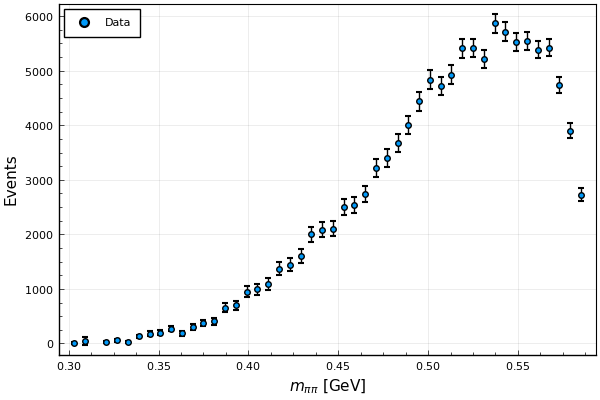

In [14]:
plt_data(data, xlab = L"m_{\pi\pi}" * " [GeV]", ylab = "Events")

In [24]:
const M = 3.686; const mπ = 0.14; const mJ = 3.097; 

λ(x, y, z) = x^2 + y^2 + z^2 - 2x*y - 2y*z - 2z*x

# a simple function that will be used to fit the data: QCD multipole expansion model for ψ'→J/ψπ⁺π⁻
# The important ππ FSI effect is not taken into account
# bg is just for introducing a third parameter
function dist(w, N, c, bg) 
    if (w ≤ 2mπ || w ≥ M-mJ)
        res = 0.0
    else
        q1 = sqrt(λ(w^2, mπ^2, mπ^2))/(2w)
        q2 = sqrt(λ(M^2, w^2, mJ^2))/(2M)
        res = N * q1 * q2 * (w^2 - c*mπ^2)^2 + bg
    end
    return res * 1e6
end;

dist(x, p) = dist(x, p...)

dist (generic function with 2 methods)

In [25]:
# parameters in an array/tuple
# χsq(par) = chisq((x, p) -> dist(x, p...), data, par)
χsq(par) = chisq(dist, data, par)

# parameters given individually
χsq1(N, c, bg) = chisq(dist, data, (N, c, bg));

In [17]:
@time χsq((1, 2, 0.1))

  0.000002 seconds


1.8242263849114743e8

In [18]:
# parameters are collected into a tuple or an array, which is the only variable of χsq
gradf(par) = gradient(χsq, par)
fit = Minuit(χsq, [1, 2, 0], error = 0.1*ones(3), grad = gradf)
fit.strategy = 1;

In [19]:
# all parameters are vairables of χsq
fit1 = Minuit(χsq1, N = 1, c = 2, bg = 0, error_N = 0.1, error_c = 0.1, error_bg = 0.1)
fit1.strategy = 1;

In [20]:
@btime migrad(fit)
minos(fit)
migrad(fit)

  106.100 μs (1443 allocations: 36.52 KiB)


PyObject MigradResult(fmin=FMin(fval=64.67993733507895, edm=9.357751294516442e-15, tolerance=0.1, nfcn=3, ncalls=117711, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=2.6114833151653025, error=0.05177673323060879, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=4.201031332818215, error=0.09311776395965805, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=-2.1921187450274414e-05, error=1.1895993246464892e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [21]:
@btime migrad(fit1)
minos(fit1)
migrad(fit1)

  90.900 μs (565 allocations: 10.80 KiB)


PyObject MigradResult(fmin=FMin(fval=64.679937335079, edm=1.5156345070287753e-14, tolerance=0.1, nfcn=14, ncalls=663932, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='N', value=2.6114833211935484, error=0.051776712195704004, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='c', value=4.201031344545451, error=0.09311685621270735, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='bg', value=-2.192118618207932e-05, error=1.1895620973146581e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [22]:
minos(fit1)

PyObject MErrors([('N', MError(name='N', is_valid=True, lower=-0.05145257573454067, upper=0.05210385773044046, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=56, min=2.6114833211935484)), ('c', MError(name='c', is_valid=True, lower=-0.09392066407552968, upper=0.09232893682255511, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=56, min=4.201031344545451)), ('bg', MError(name='bg', is_valid=True, lower=-1.2031491205034717e-05, upper=1.1765608570813917e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=56, min=-2.192118618207932e-05))])

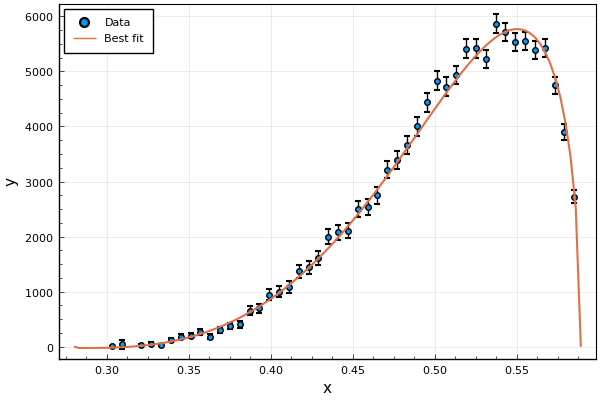

In [27]:
plt_best(dist, fit, data, xrange = (2mπ, M-mJ))

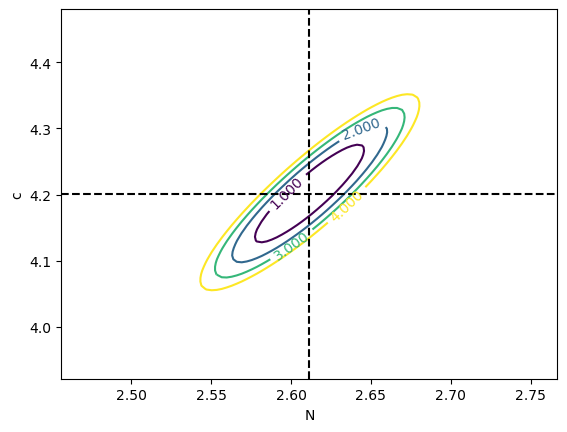

([2.4561531846064364, 2.4592911671637516, 2.4624291497210673, 2.4655671322783825, 2.4687051148356978, 2.4718430973930134, 2.4749810799503287, 2.4781190625076444, 2.4812570450649596, 2.484395027622275  …  2.738571614764822, 2.7417095973221373, 2.7448475798794525, 2.747985562436768, 2.7511235449940834, 2.7542615275513986, 2.7573995101087143, 2.7605374926660295, 2.7636754752233452, 2.7668134577806605], [3.9216807759073293, 3.9273242217384023, 3.932967667569476, 3.938611113400549, 3.944254559231622, 3.9498980050626953, 3.9555414508937683, 3.9611848967248418, 3.9668283425559148, 3.972471788386988  …  4.429590900703915, 4.435234346534989, 4.440877792366061, 4.446521238197135, 4.452164684028208, 4.457808129859281, 4.463451575690354, 4.469095021521428, 4.4747384673525, 4.480381913183574], [20.972585684547113 20.022934908552898 … 290.280110975979 296.3574252092246; 21.148382447267153 20.131613966475754 … 285.0424527312081 291.0755140159173; … ; 350.8725474805894 342.54598215294766 … 19.82633942

In [29]:
# MIGRAD contour of two parameters with the other ones fixed
# needs PyPlot or the pyplot backend of Plots
fit1.draw_contour(:N, :c, bound=3, bins=100)

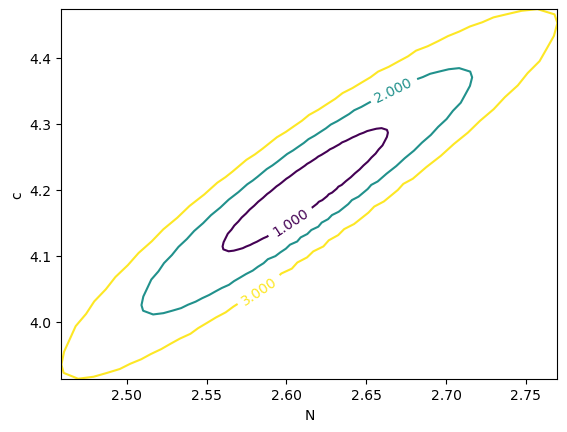

PyObject <matplotlib.contour.ContourSet object at 0x7f755a2b6f90>

In [30]:
# contour of parameter space from MINOS
fit1.draw_mncontour(:N, :c, nsigma=3, numpoints=100)

In [31]:
matrix(fit1, correlation = true)

PyObject ((1.0, 0.9252133738369328, 0.6055255848641659), (0.9252133738369328, 1.0, 0.7483973089680895), (0.6055255848641659, 0.7483973089680895, 1.0))

In [32]:
@show fit1.matrix
matrix(fit1)

fit1.matrix = ((0.0026808279257967637, 0.004460717050849894, 3.729529830296808e-7), (0.004460717050849894, 0.008670748910938015, 8.289868474538332e-7), (3.729529830296808e-7, 8.289868474538332e-7, 1.4150579833676482e-10))


PyObject ((0.0026808279257967637, 0.004460717050849894, 3.729529830296808e-07), (0.004460717050849894, 0.008670748910938015, 8.289868474538332e-07), (3.729529830296808e-07, 8.289868474538332e-07, 1.4150579833676482e-10))

In [34]:
# this gives parameter sets at the 1σ boundary
@time contour_df(fit1, χsq1, npts = 5)

  0.030519 seconds (68.56 k allocations: 1.641 MiB)


,χ²,N,c,bg
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.6799,2.56003,4.11414,-2.93031e-5
3,65.6799,2.66359,4.28643,-1.48855e-5
4,65.68,2.56385,4.10711,-3.10184e-5
5,65.6799,2.65961,4.29336,-1.32339e-5
6,65.68,2.5798,4.13027,-3.39527e-5
7,65.68,2.64221,4.2688,-1.01556e-5
8,65.68,2.56003,4.11439,-2.92436e-5
9,65.6799,2.5638,4.10711,-3.10202e-5


In [44]:
# random sampling of parameters in given ranges, keeping those within 1σ
@time parsam_df = contour_df_samples(fit1, χsq1, (:N, :c), ([2.5,2.8], [4.0,4.3]), nsamples = 3000)

  1.783094 seconds (3.80 M allocations: 110.188 MiB, 4.15% gc time)


,χ²,N,c,bg
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.2247,2.63625,4.22217,-2.18093e-5
3,65.0267,2.60043,4.16315,-2.67412e-5
4,65.0163,2.58483,4.14695,-2.72739e-5
5,64.786,2.60243,4.19567,-2.15604e-5
6,65.0851,2.62754,4.20807,-2.29681e-5
7,65.2116,2.62994,4.25398,-1.56921e-5
8,65.4255,2.59603,4.20397,-1.93223e-5
9,65.5859,2.56342,4.12654,-2.76742e-5


In [45]:
# get parameter ranges
extrema(parsam_df.:N), extrema(parsam_df.:c)

((2.561320440146716, 2.6624541513837947), (4.111837279093031, 4.288096032010671))

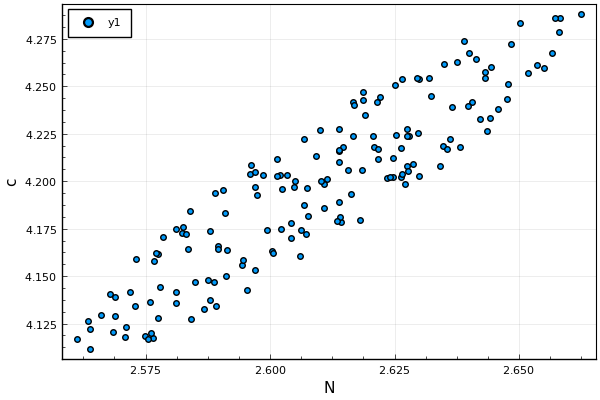

In [51]:
scatter(parsam_df.:N, parsam_df.:c, xlab = "N", ylab = "c")

In [38]:
@time contour_df_samples(fit, χsq, (:x0, :x1, :x2), ([2.5,2.8],  [4.0,4.3], (-3e-5,3e-5)), nsamples = 1000)

  0.446644 seconds (848.99 k allocations: 28.235 MiB, 5.62% gc time)


,χ²,x0,x1,x2
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.5178,2.61081,4.2048,-2.78979e-5
3,65.3242,2.65165,4.26066,-1.84084e-5
4,64.9696,2.63904,4.24955,-1.78679e-5
5,65.6072,2.61862,4.23544,-2.24324e-5
6,65.0331,2.58318,4.14745,-2.80781e-5
7,65.1127,2.64084,4.25646,-1.87688e-5
8,65.0023,2.62523,4.21411,-1.85285e-5
9,65.4548,2.5988,4.2015,-2.44144e-5


In [57]:
@time contour_df_samples(fit, χsq, :x0, (2.5,2.8), nsamples = 20)

  0.033775 seconds (335.09 k allocations: 6.470 MiB)


,χ²,x0,x1,x2
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.5614,2.56316,4.11968,-2.88302e-5
3,65.0779,2.57895,4.14646,-2.65198e-5
4,64.785,2.59474,4.17304,-2.42721e-5
5,64.6803,2.61053,4.19944,-2.20544e-5
6,64.7617,2.62632,4.2256,-1.98768e-5
7,65.0271,2.64211,4.2515,-1.77407e-5
8,65.4744,2.65789,4.27721,-1.56345e-5


## Example A in the iminuit tutorial

The example is [Example A: Fit of a gaussian model to a histogram](https://nbviewer.jupyter.org/github/scikit-hep/iminuit/blob/master/tutorial/automatic_differentiation.ipynb)

In [58]:
using PyCall

In [59]:
# import numpy from Python to generate the same data as in the example
np = pyimport(:numpy)
default_rng = pyimport("numpy.random").default_rng
rng = default_rng(seed=1)
const w, xe = np.histogram(rng.normal(0, 1, 10000), bins=1000)

([1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [-3.8378621427178974, -3.830092502694802, -3.8223228626717063, -3.8145532226486107, -3.806783582625515, -3.7990139426024196, -3.791244302579324, -3.7834746625562286, -3.775705022533133, -3.7679353825100375  …  3.8618511201697956, 3.869620760192891, 3.8773904002159867, 3.8851600402390822, 3.892929680262178, 3.9006993202852733, 3.908468960308369, 3.9162386003314644, 3.92400824035456, 3.931777880377655])

In [60]:
# define the model and the score function to minimize
using SpecialFunctions

function cdf(x, par)
    mu, sigma = par
    z = (x - mu) / sigma
    return 0.5 * (1 + erf(z / sqrt(2))) 
end

function score(par)
    amp = par[1]
    rest = par[2:end]
    mu = amp * (cdf.(xe[2:end], Ref(rest)) - cdf.(xe[1:end-1], Ref(rest)) )
    return 2 * sum(@. mu - w * log(mu + 1e-100))
end

score (generic function with 1 method)

In [61]:
const start_values = [1.5 * sum(w), 1.0, 2.0]
const limits = [(0, nothing), nothing, (0, nothing)];

In [62]:
# w/o grad
m = Minuit(score, start_values, limit=limits)
m.strategy = 0

# using grad
grad_fd(pars) =  gradient(score, pars)
m_fd = Minuit(score, start_values, limit=limits, grad = grad_fd)
m_fd.strategy = 0;

In [63]:
@btime migrad(m)

  627.100 μs (475 allocations: 460.64 KiB)


PyObject MigradResult(fmin=FMin(fval=-38710.19985212475, edm=2.0142820069460498e-12, tolerance=0.1, nfcn=8, ncalls=39692, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=10001.040137685515, error=99.56265139939478, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None), Param(number=1, name='x1', value=-0.01105171350465089, error=0.010013546547205668, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=0.9992897105689829, error=0.007141203766656945, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None)])

In [64]:
@btime migrad(m_fd)

  380.300 μs (257 allocations: 348.22 KiB)


PyObject MigradResult(fmin=FMin(fval=-38710.19985212736, edm=9.414200054796711e-12, tolerance=0.1, nfcn=3, ncalls=27164, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=10001.039987391317, error=99.95742260033421, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None), Param(number=1, name='x1', value=-0.011051729329187911, error=0.009992544958620243, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=0.9992893655857928, error=0.00710107169380747, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None)])